# 3. Clustering

packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

importation des données

In [2]:
PATH = 'data/'
DATA = 'auto-mpg.csv'
HEADER = ['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model year', 'origin', 'car name']
feature_name = ['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model year', 'origin']
target_name = 'car name'

séparation des données, pour avoir les features et la classe target

In [3]:
dataset = pd.read_csv(PATH+DATA, sep=',', na_values='?', header=None, names=HEADER)
X = dataset[feature_name]
y = dataset[target_name]

## Traitement des données manquantes

On utilise `SimpleImputer` pour remplacer les données manquantes par les valeurs moyennes des colonnes.  
Dans notre cas, seul l'attribut `horsepower` contient des données manquantes, on les remplace donc par la valeur moyenne de cette attribut

In [4]:
from sklearn.impute import SimpleImputer

simple_imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
Xm = simple_imputer.fit_transform(X)

Xm = pd.DataFrame(Xm, columns=feature_name)

print(Xm.head())

    mpg  cylinders  displacement  horsepower  weight  acceleration  \
0  18.0        8.0         307.0       130.0  3504.0          12.0   
1  15.0        8.0         350.0       165.0  3693.0          11.5   
2  18.0        8.0         318.0       150.0  3436.0          11.0   
3  16.0        8.0         304.0       150.0  3433.0          12.0   
4  17.0        8.0         302.0       140.0  3449.0          10.5   

   model year  origin  
0        70.0     1.0  
1        70.0     1.0  
2        70.0     1.0  
3        70.0     1.0  
4        70.0     1.0  


## Projection des données en 2D (Analyse en composantes principales) 

In [5]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_projected = pca.fit_transform(Xm)

X_projected = pd.DataFrame(X_projected, columns=['x', 'y'])
print(X_projected.head())
print(X_projected.describe())

            x          y
0  543.685195  51.016856
1  737.587369  79.388859
2  478.214175  75.633477
3  473.650482  62.759211
4  488.912957  55.984237
                  x             y
count  3.980000e+02  3.980000e+02
mean  -1.279691e-13  1.599614e-14
std    8.530837e+02  3.882194e+01
min   -1.362803e+03 -1.218380e+02
25%   -7.522943e+02 -1.889189e+01
50%   -1.696310e+02 -2.194614e+00
75%    6.409416e+02  1.699202e+01
max    2.180090e+03  2.699104e+02


<AxesSubplot:xlabel='x', ylabel='y'>

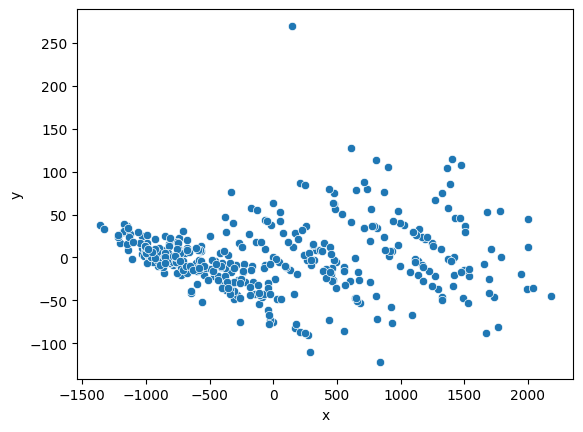

In [6]:
sns.scatterplot(data=X_projected, x="x", y="y")

Dans la colonne précédente, on voit que les valeurs min, max, moyenne pour x et y sont :  

|  | x | y |
|----------|----------|----------|
| min |  -1363 | -121 |
| mean | 0 | 0 |
| max | 2180 | 270 |

On remarque qu'un échantillons est séparer des autres, il a une valeur plus grande pour `y`

## Traitement des valeurs abérantes

On retire l'échantillon que nous avons remarqué, celui qui a une valeur de y>200

In [7]:
X_projected = X_projected[X_projected['y'] < 200]

print(X_projected.describe())

                 x           y
count   397.000000  397.000000
mean     -0.376225   -0.679875
std     854.127113   36.421381
min   -1362.802522 -121.838032
25%    -753.785912  -18.967788
50%    -173.470155   -2.217743
75%     641.536706   16.882969
max    2180.089927  127.822934


<AxesSubplot:xlabel='x', ylabel='y'>

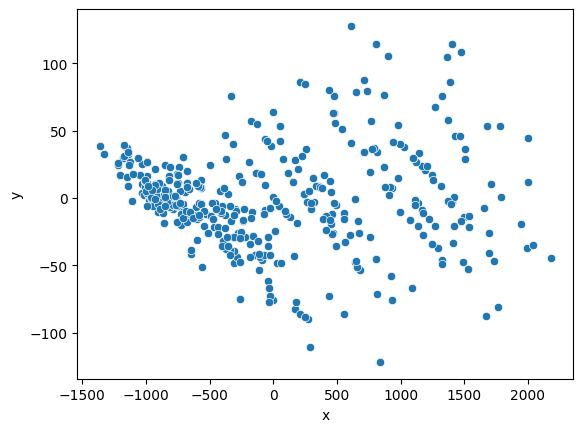

In [8]:
sns.scatterplot(data=X_projected, x="x", y="y")

## Analyse visuelle

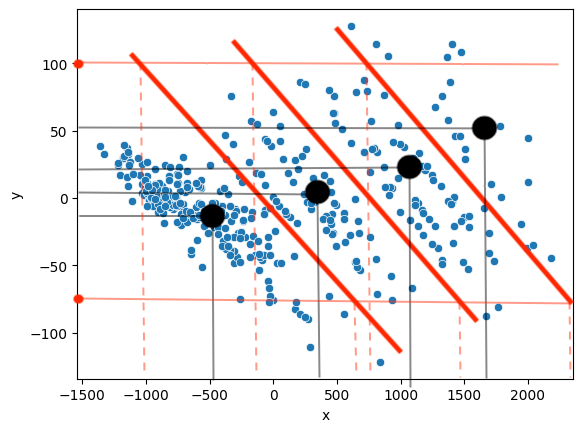

In [9]:
from IPython import display

display.Image("./3_Expected_Clusters.png")

Si l'image ne s'affiche pas, il s'agit de l'image `3_Expected_Clusters.png`  

Visuellement, on remarque 4 clusters.  
Les clusters sont séparés par les 3 droites rouges.  
On décide d'appliquer l'algorithme des `Kmeans` on imposant les centroids d'origine (ici en noir)

In [10]:
# Cluster visuel :

def get_line_coeff(x1, x2, y1, y2):
    A = (y1-y2)/(x1-x2)
    B = y1 - A*x1
    return A, B

def f1(x):
    A, B = get_line_coeff(x1=-1050, x2 = 600, y1=100, y2=-75)
    return A*x + B

def f2(x):
    A, B = get_line_coeff(x1=-100, x2 = 1500, y1=100, y2=-75)
    return A*x + B

def f3(x):
    A, B = get_line_coeff(x1=750, x2 = 2200, y1=100, y2=-75)
    return A*x + B

def expected_cluster(x, y):
    if y <= f1(x):
        return 0
    elif y <= f2(x):
        return 1
    elif y <= f3(x):
        return 2
    else:
        return 3

In [11]:
expected_cluster_list = []

for i in X_projected.index:
    x = X_projected['x'][i]
    y = X_projected['y'][i]
    c = expected_cluster(x, y)
    expected_cluster_list.append(c)

X_all = X_projected.copy(deep=True)
X_all['expected_cluster'] = expected_cluster_list

X_all.head()

,x,y,expected_cluster
0,543.685195,51.016856,2
1,737.587369,79.388859,2
2,478.214175,75.633477,2
3,473.650482,62.759211,2
4,488.912957,55.984237,2


<AxesSubplot:xlabel='x', ylabel='y'>

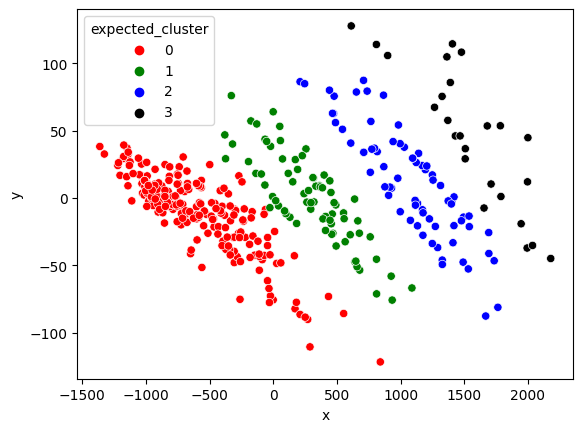

In [12]:
sns.scatterplot(data=X_all, x="x", y="y", hue="expected_cluster", palette=['red', 'green', 'blue', 'black'])

## Kmeans

On tente de faire ressortir 4 clusters en appliquant les K means

### centroids

In [13]:
centroids = [ [-500, -10], [400, 10], [1050, 20], [1700, 55] ]

In [14]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4, n_init=1, init=centroids, max_iter=2, algorithm="elkan")
X_clusters = kmeans.fit_predict(X_projected)

print(X_clusters)

[1 2 1 1 1 3 3 3 3 2 1 2 2 0 1 1 0 0 0 0 0 0 0 0 3 3 3 3 0 0 0 0 0 1 1 1 1
 2 3 2 2 3 3 3 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 2 3 2 2 2 3 3 3 3 0 2 2 3
 2 1 0 1 0 0 0 0 0 0 2 2 2 2 2 3 3 3 2 3 3 2 1 1 1 1 1 0 3 3 3 3 1 0 0 0 0
 0 0 0 2 3 0 0 0 1 1 0 1 2 1 1 1 1 0 0 0 0 2 2 2 2 3 3 3 2 0 0 0 0 0 0 0 0
 0 0 0 1 1 1 1 3 3 3 3 2 2 2 2 1 1 1 0 0 1 0 0 0 0 1 0 1 0 1 1 0 0 0 0 0 0
 0 2 2 2 2 1 1 1 1 0 0 0 0 2 1 2 1 0 0 0 0 1 2 1 1 2 3 2 2 2 0 0 0 0 0 2 2
 2 3 1 1 2 1 2 2 3 3 0 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1 2 1 1 1 1 0 1 1 1 1
 2 1 1 1 1 2 0 0 0 0 0 1 1 0 1 1 1 1 0 0 1 1 1 1 1 2 2 2 2 3 2 2 2 0 0 0 0
 1 2 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 1 0 0 0 1 1 0 0 0 0 1
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 2 1 1 0 0 0 0
 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 1 1 0 0 0 0]


Comme les centroids initiaux sont imposés, `n_init` doit être à 1. On limite aussi le nombre d'itération afin que l'algorithme respecte les centroids initiaux.

In [15]:
X_all['cluster'] = X_clusters

print(X_all.describe())

                 x           y  expected_cluster     cluster
count   397.000000  397.000000        397.000000  397.000000
mean     -0.376225   -0.679875          0.740554    0.876574
std     854.127113   36.421381          0.966976    1.011240
min   -1362.802522 -121.838032          0.000000    0.000000
25%    -753.785912  -18.967788          0.000000    0.000000
50%    -173.470155   -2.217743          0.000000    1.000000
75%     641.536706   16.882969          1.000000    2.000000
max    2180.089927  127.822934          3.000000    3.000000


<AxesSubplot:xlabel='x', ylabel='y'>

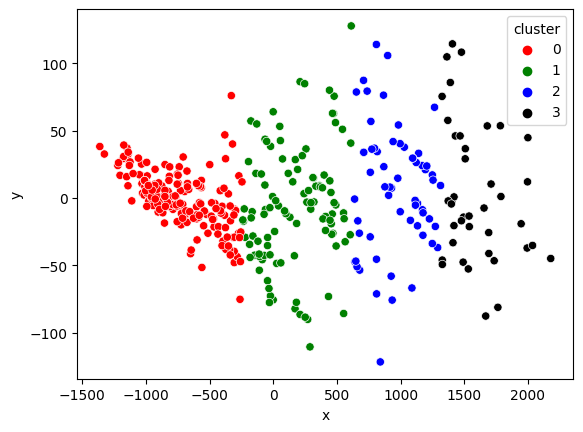

In [16]:
sns.scatterplot(data=X_all, x="x", y="y", hue="cluster", palette=['red', 'green', 'blue', 'black'])

## Confusion Matrix

[[186  38   1   0]
 [  4  58  13   0]
 [  0   9  44  19]
 [  0   1   3  21]]


<AxesSubplot:>

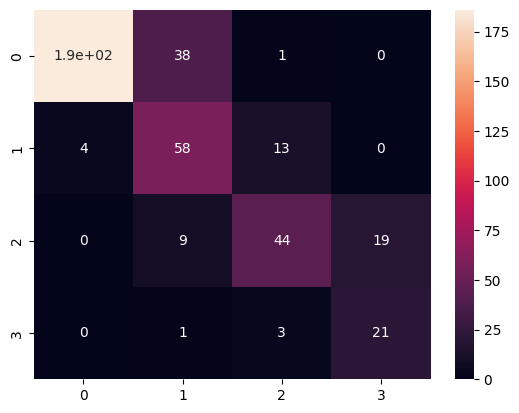

In [17]:
from sklearn import metrics

M = metrics.confusion_matrix(X_all['expected_cluster'], X_all['cluster'])
print(M)
sns.heatmap(M, annot=True)

In [18]:
from sklearn import metrics

report = metrics.classification_report(X_all['expected_cluster'], X_all['cluster'])
print(report)

              precision    recall  f1-score   support

           0       0.98      0.83      0.90       225
           1       0.55      0.77      0.64        75
           2       0.72      0.61      0.66        72
           3       0.53      0.84      0.65        25

    accuracy                           0.78       397
   macro avg       0.69      0.76      0.71       397
weighted avg       0.82      0.78      0.79       397



La tableau ci-dessus présente les scores entre les clusters trouvés par `kmeans` et ceux attendus lors de la visualisation.  
Les précisions sont fortes pour les classes 0 et 2, les rappels sont meilleurs pour les classes 1 et 3.
Le taux de bonne classification est de 78 %.

L'algorithme Kmeans fait surtout des séparations selon des droites verticales.

## Conclusion

Une projection des données en 2D nous permet d'avoir une visualisation des données.  
Cela permet d'abord de repérer des anomalies et de proposer visuellement des clusters. 

Le fait d'indiquer les centroids et de limiter le nombre d'itération permet de retrouver globalement les clusters à la bonne position. En revanche, le taux de bonne classification selon les clusters attendus visuellement est encore faible.  

Pour améliorer le modèle, il faudrait faire varier le nombre d'itérations. Il est aussi possible de chercher des algorithmes basés sur des distances plus adéquat.